In [1]:
import torch
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
import pickle as pickle
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# initial rotate H or S func.


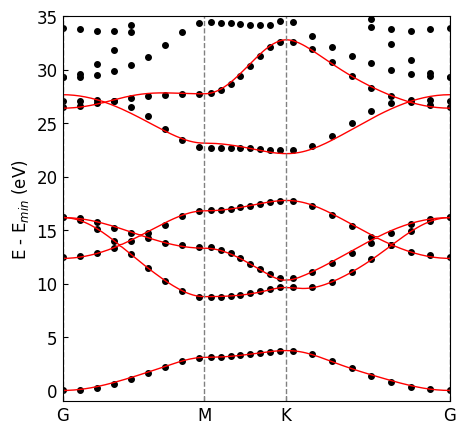

In [4]:
# load model in pth format
checkfile = './ext/checkpoint/latest_nnsk_b3.600_c3.599_w0.300.pth'
checkfile = './spds/checkpoint/latest_nnsk_b3.600_c3.600_w0.300.pth'
checkfile = './long/checkpoint/latest_nnsk_b3.600_c3.600_w0.300.pth'

f = torch.load(checkfile)
# define nnskapi for tb model.
nnskapi = NNSKHost(checkpoint=checkfile)
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
# define nnHrk for Hamiltonian model.
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

# set the input parameters for band structure calculation.
# structure: the path of the structure file.
run_opt={"structure":"./data/struct.vasp",
        "results_path":"./"}
# jdata: the input parameters for band structure calculation.

jdata={"kline_type":"abacus",
        "kpath":[
            [0, 0, 0, 50],
            [0.5, 0, 0, 50],
            [0.3333333, 0.3333333, 0, 50],
            [0, 0, 0, 1]
        ],
        "nkpoints":151,
        "klabels":["G", "M", "K", "G"],
        "E_fermi":-7.5,
        "emin":-23,
        "emax":12
        }
# call bandcalc to calculate the band structure.
bcalc = bandcalc(apiHrk=nnHrk,run_opt=run_opt,jdata=jdata)
eigenstatus = bcalc.get_bands()

# load the DFT band data.
#band = np.loadtxt('../data/soc/BANDS_1.dat')
band = np.load("./data/kpath.0/eigs.npy")[0]
# plot figures.
plt.figure(figsize=(5,5),dpi=100)
# in DFT band data, the first column  is column index, the second is the kpoints, 
# the 3rd column is the eigenvalues of the first band, the 4th column is the eigenvalues of the second band, and so on.
# Here, the  the first 20 bands are core eletronic bands, not fitting in TB model.
plt.plot(eigenstatus['xlist'][::6], band[::6,:] - np.min(band[:,:]),'ko',ms=4)
# set the minimum eigenvalue as 0.
plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues']- np.min(eigenstatus['eigenvalues']), 'r-',lw=1)

plt.ylim(-1,35)
for ii in eigenstatus['high_sym_kpoints']:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')

plt.xlim(eigenstatus['xlist'].min(),eigenstatus['xlist'].max())

plt.ylabel('E - E$_{min}$ (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(eigenstatus['high_sym_kpoints'], eigenstatus['labels'], fontsize=12)
plt.show()

30

In [83]:
eig = np.load('./data/kpath.0/eigs.npy')
kps = np.load('./data/kpath.0/kpoints.npy')

In [54]:
np.save('./data/kpath_sparse.0/eigs.npy',eig[:,::6])
np.save('./data/kpath_sparse.0/kpoints.npy',kps[::6])

